In [4]:
# importing data
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X_iris = iris.data[:, [2,3]]
y_iris = iris.target

print ('Class labels:', np.unique(y_iris))

Class labels: [0 1 2]


In [5]:
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_iris,
                                                    y_iris,
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=y_iris) # ensures we have proporitonal class labels

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [7]:
# training perceptron on the data
from sklearn.linear_model import Perceptron
ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
      fit_intercept=True, max_iter=40, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=1, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
# accuracy of perceptron on test data
y_pred = ppn.predict(X_test_std)
print ('Misclassified samples: %d' % (y_test - y_pred).sum())

Misclassified samples: 9


In [9]:
# sklearn performance metrics
from sklearn.metrics import accuracy_score
print ('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
# OR
print ('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

Accuracy: 0.80
Accuracy: 0.80


In [11]:
# updated function for plotting decision regions
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0],
                    y=X[y==cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
        
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set'
                    )

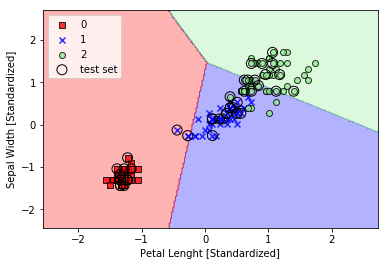

In [12]:
# using our new plotting function with perceptron classifier
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105,150)
                      )
plt.xlabel('Petal Lenght [Standardized]')
plt.ylabel('Sepal Width [Standardized]')
plt.legend(loc='upper left')
plt.show()

# Logistic Regression

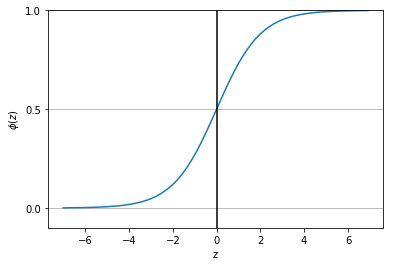

In [13]:
# visualizing the sigmoid function, the basis of logistic regression
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)

phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 0.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

plt.yticks([0.0, 0.5, 1.0])
ax=plt.gca()
ax.yaxis.grid(True)
plt.show()

In [14]:
# converting adaline implementation into algorithm for logistic regression

class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent
    
    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset
    random_state : int
        Random number generator seed for random weight initialization
        
    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting
    cost_ : list
        Logistic cost function value in feach epoch
        
    """
    
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """Fit training data
        
        Parameters
        -----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors
        y : array-like, shape = [n_samples]
            Target values
        
        Returns
        --------
        self : object
        """
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0,
                           scale=0.01,
                           size=1 + X.shape[1])
        
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic 'cost' now
            # instead of the sum of squared errors cost
            cost = (-y.dot(np.log(output)) - ((1-y).dot(np.log(1-output))))
            self.cost_.append(cost)
            
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
            

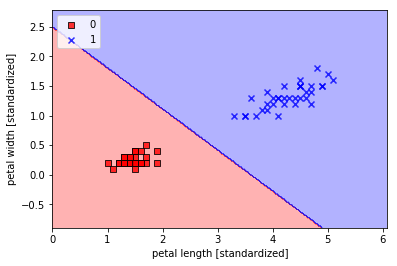

In [15]:
X_train_01_subset = X_train[np.logical_or((y_train)==0, (y_train)==1)]
y_train_01_subset = y_train[np.logical_or((y_train)==0, (y_train)==1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=10000, random_state=1)

lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


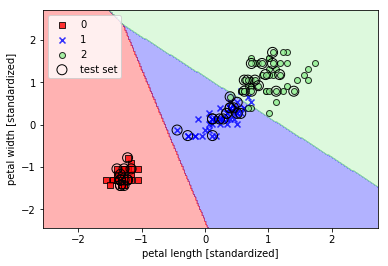

In [16]:
# training a logistic regression model with scikit learn
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=lr,
                      test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show() 

/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logisti

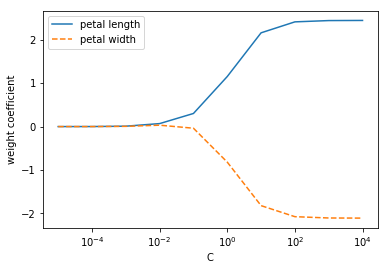

In [17]:
# visualizing regularization

weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

plt.plot(params, weights[:,0],
         label='petal length')
plt.plot(params, weights[:,1],
         linestyle='--',
         label='petal width')

plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

# Support Vector Machines (SVMs)

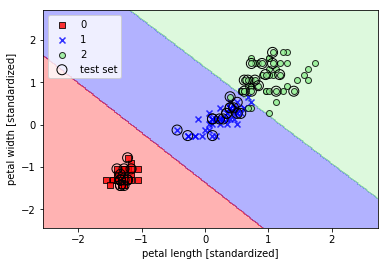

In [18]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)

svm.fit(X_train_std, y_train)

plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=svm,
                      test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show() 

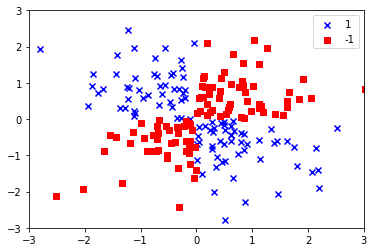

In [19]:
# kernal methods for linearly inseperable data

# lets start by visualizing some data that is linearly inseperable
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:,1] > 0)

y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor== 1, 0],
            X_xor[y_xor== 1, 1],
            c='b',
            marker='x',
            label='1')

plt.scatter(X_xor[y_xor== -1, 0],
            X_xor[y_xor== -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend(loc='best')
plt.show()

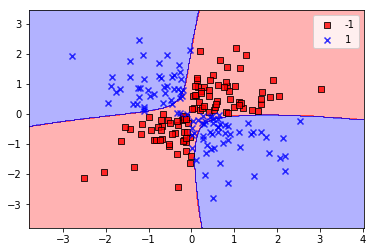

In [20]:
# training a kernel SVM to draw a non-linear decision boundary
# rbf = Radial Basis Function Kernel (or Gaussian kernel)
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='best')
plt.show()

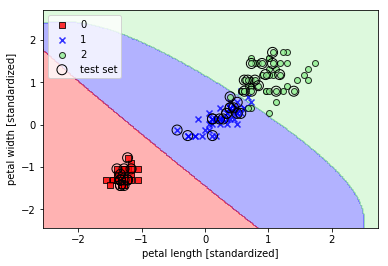

In [21]:
# exploring the gamma parameter

# gamma can be understood as a 'cut-off' parameter for the Gaussian sphere
# higher amma -> increased influence of training samples -> tighter and bumpier decision boundary

# let's demonstrate on the Iris dataset, starting with a small gamma of 0.2
svm = SVC(kernel='rbf', gamma=0.2, C=1.0, random_state=1)

svm.fit(X_train_std, y_train)

plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=svm,
                      test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

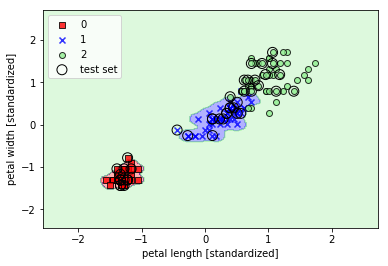

In [22]:
# now, increase the value of gamma and note the difference in the decision boundary
# if gamma is too high, the model will be overfit and fail to generalize
svm = SVC(kernel='rbf', gamma=100.0, C=1.0, random_state=1)

svm.fit(X_train_std, y_train)

plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=svm,
                      test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

# Decision Tree Learning

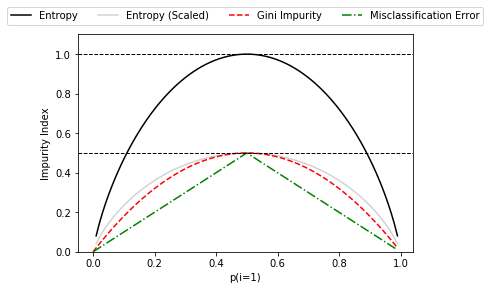

In [23]:
# visualizing different impurity criteria

# functions for impurity criteria
def gini(p):
    return (p)*(1-p) + (1-p)*(1-(1-p))
def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2((1-p))
def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(p) for p in x]

fig, ax = plt.subplots()

for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (Scaled)', 'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, color=c)
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

# from this, we can see Gini is an intermediate measure between entropy
# and classification error

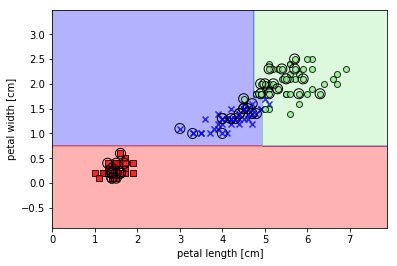

In [24]:
# building a decision tree for the Iris dataset
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini',
                              max_depth=4,
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined,
                      y_combined,
                      classifier=tree,
                      test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.show()

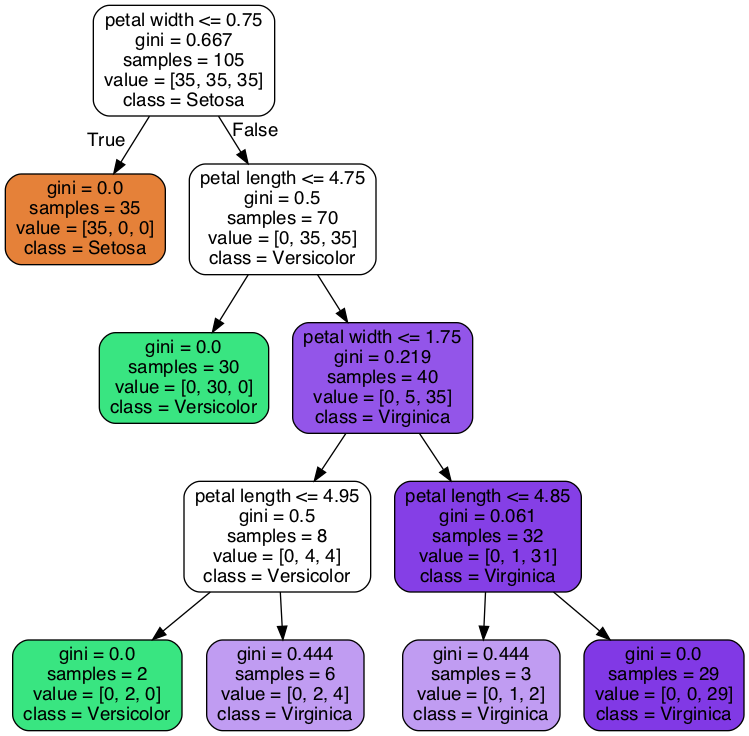

In [27]:
# visualizing the decision tree using pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree,
                           filled=True,
                           rounded=True,
                           class_names = ['Setosa', 'Versicolor', 'Virginica'],
                           feature_names = ['petal length', 'petal width'],
                           out_file=None)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

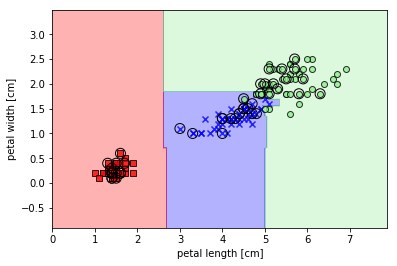

In [28]:
# using random forests classifier on the iris dataset
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini', 
                                n_estimators=25,
                                random_state=1,
                                n_jobs=2) # controls number of cores used by your computer
forest.fit(X_train, y_train)
plot_decision_regions(X_combined,
                      y_combined,
                      classifier=forest,
                      test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.show()

# K-Nearest Neighbors

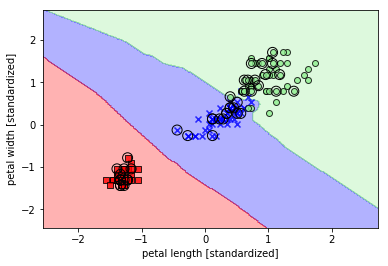

In [33]:
# implementing k nearest neighbors for iris dataset
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,
                           p=2,
                           metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=knn,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.show()